In [85]:
import numpy as np
import pandas as pd

from scipy import stats
import itertools
from sklearn import linear_model
from numpy import ones,vstack
from numpy.linalg import lstsq
pd.set_option('display.max_rows', 200)

In [2]:
df = pd.read_csv("../data/Ames_Housing_Price_Data_raw.csv", index_col=0)

In [3]:
# reset index bc data has rows with same indices, i.e. indices start over at 1 at certain points
df = df.reset_index(drop = True)

# Type dictionaries

In [4]:
typedict = {'PID' : 'nominal',
            'SalePrice' : 'continuous',
            #Matt
            'LotFrontage' : 'continuous', 
            'LotArea' : 'continuous',
            'maybe_LotShape' : 'nominal',
            'LandSlope' : 'nominal', 
            'LandContour' : 'nominal', 
            'maybe_MSZoning' : 'nominal', 
            'Street_paved' : 'nominal', 
            'Alley' : 'nominal',
            'Neighborhood' : 'nominal', 
            'drop_LotConfig' : 'nominal', 
            'drop_Condition1' : 'nominal', 
            'drop_Condition2' : 'nominal',
            'Foundation' : 'nominal',
            'Utilities' : 'nominal',
            'Heating' : 'nominal',
            'HeatingQC_nom' : 'ordinal',
            'CentralAir' : 'nominal',
            'Electrical' : 'nominal',
            'HeatingQC_ord' : 'ordinal',
            'LotShape_com' : 'nominal',
            'MSZoning_com' : 'nominal',
            'LF_Normal' : 'nominal',
            'LF_Near_NS_RR' : 'nominal',
            'LF_Near_Positive_Feature' : 'nominal',
            'LF_Adjacent_Arterial_St' : 'nominal',
            'LF_Near_EW_RR' : 'nominal',
            'LF_Adjacent_Feeder_St' : 'nominal',
            'LF_Near_Postive_Feature' : 'nominal',
            'Heating_com' : 'nominal',
            'Electrical_com' : 'nominal',
            'LotConfig_com' : 'nominal', 
            'LotFrontage_log' : 'continuous',
            'LotArea_log' : 'continuous',
            #Oren 
            'MiscFeature': 'Nominal',
            'Fireplaces': 'Discrete',
            'FireplaceQu': 'Ordinal',
            'PoolQC': 'Ordinal',
            'PoolArea': 'Continuous',
            'PavedDrive': 'Nominal',
            'ExterQual': 'Ordinal',
            'OverallQual': 'Ordinal',
            'drop_OverallCond': 'Ordinal',
            'MiscVal': 'Continuous',
            'YearBuilt': 'Discrete',
            'YearRemodAdd': 'Discrete',
            'KitchenQual': 'Ordinal',
            'Fence': 'Ordinal',
            'RoofStyle': 'Nominal',
            'RoofMatl': 'Nominal',
            'maybe_Exterior1st': 'Nominal',
            'drop_Exterior2nd': 'Nominal',
            'drop_ExterCond': 'Ordinal',
            'maybe_MasVnrType': 'Nominal',
            'MasVnrArea': 'Continuous',
            #Mo
            #Basement
            'BsmtQual_ord': 'Ordinal',
            'BsmtCond_ord': 'Ordinal',
            'BsmtExposure_ord': 'Ordinal',
            'BsmtQual_ord_lin': 'Ordinal',
            'BsmtCond_ord_lin': 'Ordinal',
            'BsmtExposure_ord_lin': 'Ordinal',
            'TotalBsmtSF': 'Continuous',
            'BSMT_GLQ':'Continuous', 
            'BSMT_Rec':'Continuous',
            'maybe_BsmtUnfSF': 'Continuous',
            'maybe_BSMT_ALQ':'Continuous',
            'maybe_BSMT_BLQ':'Continuous', 
            'maybe_BSMT_LwQ':'Continuous', 
            'drop_BsmtQual': 'Nominal',
            'drop_BsmtCond': 'Nominal',
            'drop_BsmtExposure': 'Nominal',
            'drop_BsmtFinType1': 'Nominal',
            'drop_BsmtFinSF1': 'Continuous',
            'drop_BsmtFinType2': 'Nominal',
            'drop_BsmtFinSF2': 'Continuous',
            #Deck
            'WoodDeckSF':'Continuous', 
            'OpenPorchSF':'Continuous', 
            'ScreenPorch':'Continuous',
            'maybe_EnclosedPorch':'Continuous',
            'maybe_3SsnPorch':'Continuous',
            #Garage
            'GarageFinish':'Nominal', 
            'GarageYrBlt':'Continuous',
            'GarageCars':'Ordinal',
            'GarageArea':'Continuous',
            'GarageType_con':'Nominal',
            'maybe_GarageQual':'Nominal', 
            'maybe_GarageCond':'Nominal',
            'drop_GarageType':'Nominal'
}

In [5]:
#Categorization of original variables
general=['PID','SalePrice']
lot_aspects=['LotFrontage','LotArea','LotShape','LandSlope','LandContour']
building_size=['MSSubClass','BldgType','HouseStyle','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd']
location=['MSZoning','Street','Alley','Neighborhood']
location_aspects=['LotConfig','Condition1','Condition2']
amenities=['MiscFeature','Fireplaces','FireplaceQu','PoolQC','PoolArea','PavedDrive']
garage=['GarageFinish','GarageType','GarageYrBlt','GarageCars','GarageArea','GarageQual','GarageCond']
decks=['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
basement=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
utilities=['Foundation','Utilities','Heating','HeatingQC','CentralAir','Electrical']
quality_ratings=['ExterQual','OverallQual','OverallCond','MiscVal','YearBuilt','YearRemodAdd','KitchenQual','Fence','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','ExterCond','MasVnrType','MasVnrArea']
sales_aspect=['Functional','SaleCondition','SaleType','MoSold','YrSold']

# Matt

In [6]:
# ordinalize heating quality ratings
HousingQC_dict={
       'Ex':5,
       'Gd':4,
       'TA':3,
       'Fa':2,
       'Po':1,
}

df.loc[df['HeatingQC'].isna(),'HeatingQC']='0'
df['HeatingQC_ord']=df['HeatingQC'].map(lambda x: HousingQC_dict[x])
df.rename(columns={'HeatingQC':'HeatingQC_nom'}, inplace=True)

In [7]:
# LotShape: combine IR2 (moderately irregular) and IR3 (irregular) into 'Irregular' due to small sample sizes
lot_shape_dict = {
    'Reg':'Regular',
    'IR1':'Slightly irregular',
    'IR2':'Irregular',
    'IR3': 'Irregular'
}
df['LotShape_com'] = df['LotShape'].map(lambda x: lot_shape_dict[x] if x in lot_shape_dict else x)
df.rename(columns={'LotShape':'maybe_LotShape'}, inplace=True)

In [8]:
# LandSlope: combine Mod (moderate) and Sev (severe) into 'Moderate-severe' due to small sample sizes
land_slope_dict = {
    'Gtl':'Gentle',
    'Mod':'Moderate-severe',
    'Sev':'Moderate-severe'
}
df['LandSlope'] = df['LandSlope'].map(lambda x: land_slope_dict[x] if x in land_slope_dict else x)

In [9]:
# rename missing values in Alley column to 'No alley access'
alley_dict = {
    'Pave':'Paved',
    'Grvl':'Gravel',
    'No alley access' : 'No alley access'
}
df.loc[df['Alley'].isna(),'Alley'] = 'No alley access'
df['Alley'] = df['Alley'].map(lambda x: alley_dict[x] if x in alley_dict else x)

In [10]:
# simple renaming LandContour values for clarity
LandContour_dict = {
    'Lvl':'Level',
    'Bnk':'Banked (rise from street level to building)',
    'HLS' : 'Hillside (downward slope on both sides)',
    'Low' : 'Depression (upward slope on both sides)'
}

df['LandContour'] = df['LandContour'].map(lambda x: LandContour_dict[x] if x in LandContour_dict else x)

In [11]:
# Combine C(all) (commercial), I(all) (industrial), and A(agr) (agricultural) zoning types into 'Nonresidential' due to
# small sample sizes and the fact that we are focusing on residential sales
MSZoning_dict = {
    'RL':'Residential, low-density',
    'RM':'Residential, medium-density',
    'FV' : 'Residential, village',
    'RH' : 'Residential, high-density',
    'C (all)' : 'Nonresidential',
    'I (all)' : 'Nonresidential',
    'A (agr)' : 'Nonresidential'
}

df['MSZoning_com'] = df['MSZoning'].map(lambda x: MSZoning_dict[x] if x in MSZoning_dict else x)
df.rename(columns={'MSZoning':'maybe_MSZoning'}, inplace=True)

In [12]:
# combine 'Near (within 200 ft)' and 'Adjacent to' into 'Near' for North-South RR, East-West RR, and positive features (parks, greenways, etc)
# renaming them LF_<factor> for Location Factor instead of condition to avoid confusion, as condition is also used to describe
# state of maintenance of various other features in the dataset
Condition_dict = {
    'Norm' : 'LF_Normal',
    'RRAn' : 'LF_Near_NS_RR',
    'PosN' : 'LF_Near_Positive_Feature',
    'Artery' : 'LF_Adjacent_Arterial_St',
    'RRAe' : 'LF_Near_EW_RR',
    'Feedr' : 'LF_Adjacent_Feeder_St',
    'PosA' : 'LF_Near_Postive_Feature',
    'RRNn' : 'LF_Near_NS_RR',
    'RRNe' : 'LF_Near_EW_RR'
}

df['Condition1'] = df['Condition1'].map(lambda x: Condition_dict[x] if x in Condition_dict else x)
df['Condition2'] = df['Condition2'].map(lambda x: Condition_dict[x] if x in Condition_dict else x)

In [13]:
def combine_condition_columns(df, factors):
    '''
    combines the "Condition1_com" and "Condition2_com" columns into a set of dummies for the values in those 2 columns
    '''
    for i in range(0, df.shape[0]):
        for factor in factors:
            if df.loc[i, 'Condition1'] == factor or df.loc[i, 'Condition2'] == factor:
                df.loc[i, f'{factor}'] = '1'
            else:
                df.loc[i, f'{factor}'] = '0'
    return df

In [14]:
loc_factors = Condition_dict.values()
df = combine_condition_columns(df, loc_factors)

In [15]:
# recommend drop condition columns
df.rename(columns={'Condition1':'drop_Condition1'}, inplace=True)
df.rename(columns={'Condition2':'drop_Condition2'}, inplace=True)

In [16]:
df.rename(columns={'Street':'Street_paved'}, inplace=True) # renaming 'Street' to 'Street_paved'

In [17]:
# Utilities: simple renaming for clarity
Utilities_dict = {
    'AllPub':'EGWS',
    'NoSewr':'EGW with septic tank'
}

df['Utilities'] = df['Utilities'].map(lambda x: Utilities_dict[x] if x in Utilities_dict else x)

In [18]:
# combine 'Gravity furnace', 'Other water/steam heating', 'Floor furnace', and 'Wall furnace' into 'Other' due to
# small sample size
Heating_dict = {
    'GasA':'Gas-powered forced-air heating',
    'GasW':'Gas-powered water/steam heating',
    'Grav' : 'Other',
    'OthW' : 'Other',
    'Floor' : 'Other',
    'Wall' : 'Other'
}

df['Heating_com'] = df['Heating'].map(lambda x: Heating_dict[x] if x in Heating_dict else x)

In [19]:
# renaming for clarity and combining FuseP and FuseF categories due to small sample size
# they are also the 2 most undesirable electrical setups as reported by the data dictionary
Electrical_dict = {
    'SBrkr': 'Standard circuit breakers, all Romex wiring',
    'FuseA': '>60 Amp fuse box, all Romex wiring',
    'FuseF' : '60 Amp fuse box, Romex or older wiring',
    'FuseP' : '60 Amp fuse box, Romex or older wiring'
}

df['Electrical_com'] = df['Electrical'].map(lambda x: Electrical_dict[x] if x in Electrical_dict else x)

In [20]:
# combined FR2 (2 sides frontage) and FR3 (3 sides frontage) into 2+ sides frontage due to small sample size
LotConfig_dict = {
    'Inside': 'Inside lot (1 side frontage)',
    'Corner': 'Corner lot',
    'CulDSac' : 'Cul-de-sac lot',
    'FR2' : '2+ sides frontage',
    'FR3' : '2+ sides frontage'
}

df['LotConfig_com'] = df['LotConfig'].map(lambda x: LotConfig_dict[x] if x in LotConfig_dict else x)
df.rename(columns={'LotConfig':'drop_LotConfig'}, inplace=True)

In [21]:
df['LotFrontage_log'] = np.log(df['LotFrontage'])

In [22]:
df['LotArea_log'] = np.log(df['LotArea'])

# Oren

In [23]:
Cond_dict={
       'Ex':5,
       'Gd':4,
       'TA':3,
       'Fa':2,
       'Po':1,
       'NA':0,
        '0':0
}

In [24]:
df.loc[df['ExterQual'].isna(),'ExterQual']='0'
df['ExterQual']=df['ExterQual'].map(lambda x: Cond_dict[x])

df.loc[df['ExterCond'].isna(),'ExterCond']='0'
df['ExterCond']=df['ExterCond'].map(lambda x: Cond_dict[x])

df.loc[df['KitchenQual'].isna(),'KitchenQual']='0'
df['KitchenQual']=df['KitchenQual'].map(lambda x: Cond_dict[x])

df.loc[df['FireplaceQu'].isna(),'FireplaceQu']='0'
df['FireplaceQu']=df['FireplaceQu'].map(lambda x: Cond_dict[x])

In [25]:
Paved_Drive_Dict={
       'Y':'Paved' ,
       'P':'Partial Pavement',
       'N':'Dirt Gravel'
}
df['PavedDrive']=df['PavedDrive'].map(lambda x: Paved_Drive_Dict[x] if x != 'NA' else x)

Fence_Dict={
       'GdPrv':'Good Privacy',
       'MnPrv':'Minimum Privacy',
       'GdWo':'Good Wood',
       'MnWw':'Minimum Wood/Wire',
       'NA':'No Fence'
}
df.loc[df['Fence'].isna(),'Fence'] = 'NA'
df['Fence']=df['Fence'].map(lambda x: Fence_Dict[x])

Misc_Feature_Dict={
       'Elev':'Elevator',
       'Gar2':'2nd Garage',
       'Othr':'Other',
       'Shed':'Shed',
       'TenC':'Tennis Court',
       'NA':'Nothing'
}
df.loc[df['MiscFeature'].isna(),'MiscFeature'] = 'NA'
df['MiscFeature']=df['MiscFeature'].map(lambda x: Misc_Feature_Dict[x])


Roof_Style_Dict={
       'Flat':'Flat',
       'Gable':'Gable',
       'Gambrel':'Gabrel Barn',
       'Hip':'Hip',
       'Mansard':'Mansard',
       'Shed':'Shed'
}
df['RoofStyle']=df['RoofStyle'].map(lambda x: Roof_Style_Dict[x] if x != 'NA' else x)  
    
    
Roof_Matl_Dict={
       'ClyTile':'Clay or Tile',
       'CompShg':'Standard (Composite) Shingle',
       'Membran':'Membrane',
       'Metal':'Metal',
       'Roll':'Roll',
       'Tar&Grv':'Gravel & Tar',
       'WdShake':'Wood Shakes',
       'WdShngl':'Wood Shingles'
}
df['RoofMatl']=df['RoofMatl'].map(lambda x: Roof_Matl_Dict[x] if x != 'NA' else x)    
    
Exterior_Dict={
       'AsbShng':'Asbestos Shingles',
       'AsphShn':'Asphalt Shingles',
       'BrkComm':'Brick Common',
       'BrkFace':'Brick Face',
       'CBlock':'Cinder Block',
       'CemntBd':'Cement Board',
       'CmentBd':'Cement Board',
       'HdBoard':'Hard Board',
       'ImStucc':'Imitation Stucco',
       'MetalSd':'Metal Siding',
       'Other':'Other',
       'Plywood':'Plywood',
       'PreCast':'PreCast',
       'Stone':'Stone',
       'Stucco':'Stucco',
       'VinylSd':'Vinyl Siding',
       'Wd Sdng':'Wood Siding',
       'WdShing':'Wood Shingles',
       'Wd Shng':'Wood Shingles',
        'Brk Cmn':'Brick Common'
}
df['Exterior1st']=df['Exterior1st'].map(lambda x: Exterior_Dict[x] if x != 'NA' else x)
df['Exterior2nd']=df['Exterior2nd'].map(lambda x: Exterior_Dict[x] if x != 'NA' else x)

Mas_Vnr_Type_Dict={
       'BrkCmn':'Brick Common',
       'BrkFace':'Brick Face',
       'CBlock':'Cinder Block',
       'None':'None',
       'Stone':'Stone'
}
df.loc[df['MasVnrType'].isna(),'MasVnrType'] = 'None'
df['MasVnrType']=df['MasVnrType'].map(lambda x: Mas_Vnr_Type_Dict[x] if x != 'NA' else x)

In [26]:
df.rename(columns={
    # Columns to drop/maybe
    'OverallCond': 'drop_OverallCond',
    'ExterCond': 'drop_ExterCond',
    'Exterior2nd':'drop_Exterior2nd',
    'MasVnrType': 'maybe_MasVnrType',  
    'Exterior1st': 'maybe_Exterior1st',
}, inplace=True)

# Hao-Wei

# Mo

In [27]:
def variable_selection(x):
    '''
    Iterate throuh all combunaions of variables and linearly regress to find optimal variables to utilize/ drop
    '''

    lm=linear_model.LinearRegression()

    for i in range(1,len(x.columns)):
        scores = {}

        for item in set(itertools.combinations(x.columns, i)):
            lm.fit(x[list(item)], df['SalePrice'])
            scores[item]=lm.score(x[list(item)], df['SalePrice'])

        print(scores[max(scores, key=lambda key: scores[key])])
        print(max(scores, key=lambda key: scores[key]))

In [28]:
#replace nominal with ordinal variables on standard scale with even steps

def linarization_func(var_name):
    '''
    Input: ordinal variable name as string
    Function creates new variable with naming *_lin that linarizes the ordinal scale 
    based on relationship to mean sales
    Variable needs to be part of a dataframe named df, which also includes oclumn 'SalePrice'
    '''

    #linear function between min and max of mean
    meanlist=df[['SalePrice',f'{var_name}']].groupby(f'{var_name}').agg('mean')

    points = [(0,min(meanlist['SalePrice'])),(1,max(meanlist['SalePrice']))]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords, rcond=None)[0]

    #loop reassigning x: current mean, future mean(x_pos on lin function)
    dict={}

    dict[min(df[f'{var_name}'].unique())]=0
    dict[max(df[f'{var_name}'].unique())]=1

    for i in df[f'{var_name}'].unique():
        if not i in dict:
            dict[i]=(meanlist.loc[meanlist.index==i,'SalePrice'][i]-c)/m

    #new value mapping dictionary
    df[f'{var_name}_lin']=df[f'{var_name}'].map(lambda x: dict[x])


Basement

In [29]:
master_dict={
       'Ex':5,
       'Gd':4,
       'TA':3,
       'Fa':2,
       'Po':1,
       'NA':0,
        '0':0
}

exp_dict={
       'Gd':4,
       'Av':3,
       'Mn':2,
       'No':1,
       'NA':0,
        '0':0
}

In [30]:
#replace nominal with ordinal variables on standard scale with even steps
df['BsmtCond_ord']=df['BsmtCond']
df.rename(columns = {'BsmtCond': 'drop_BsmtCond'}, inplace=True)
df.loc[df['BsmtCond_ord'].isna(),'BsmtCond_ord']='0'
df['BsmtCond_ord']=df['BsmtCond_ord'].map(lambda x: master_dict[x])

df['BsmtQual_ord']=df['BsmtQual']
df.rename(columns = {'BsmtQual': 'drop_BsmtQual'}, inplace=True)
df.loc[df['BsmtQual_ord'].isna(),'BsmtQual_ord']='0'
df['BsmtQual_ord']=df['BsmtQual_ord'].map(lambda x: master_dict[x])

df['BsmtExposure_ord']=df['BsmtExposure']
df.rename(columns = {'BsmtExposure': 'drop_BsmtExposure'}, inplace=True)
df.loc[df['BsmtExposure_ord'].isna(),'BsmtExposure_ord']='0'
df['BsmtExposure_ord']=df['BsmtExposure_ord'].map(lambda x: exp_dict[x])

#create linearized variables for these three prdinal variables
linarization_func('BsmtCond_ord')
linarization_func('BsmtQual_ord')
linarization_func('BsmtExposure_ord')

#drop 'unf' and 'NaN' dummies from BsmtFinType1 and BsmtFinType2 (unf covered through separate dumym already)
#need to merge dummies for BsmtFinType1 and BsmtFinType2
df['BSMT_GLQ']=0
df['BSMT_ALQ']=0
df['BSMT_BLQ']=0
df['BSMT_LwQ']=0
df['BSMT_Rec']=0

df.loc[df['BsmtFinType1'] == 'GLQ','BSMT_GLQ']=df.loc[df['BsmtFinType1'] == 'GLQ','BsmtFinSF1']
df.loc[df['BsmtFinType2'] == 'GLQ','BSMT_GLQ']=df.loc[df['BsmtFinType2'] == 'GLQ','BsmtFinSF2']

df.loc[df['BsmtFinType1'] == 'ALQ','BSMT_ALQ']=df.loc[df['BsmtFinType1'] == 'ALQ','BsmtFinSF1']
df.loc[df['BsmtFinType2'] == 'ALQ','BSMT_ALQ']=df.loc[df['BsmtFinType2'] == 'ALQ','BsmtFinSF2']

df.loc[df['BsmtFinType1'] == 'BLQ','BSMT_BLQ']=df.loc[df['BsmtFinType1'] == 'BLQ','BsmtFinSF1']
df.loc[df['BsmtFinType2'] == 'BLQ','BSMT_BLQ']=df.loc[df['BsmtFinType2'] == 'BLQ','BsmtFinSF2']

df.loc[df['BsmtFinType1'] == 'LwQ','BSMT_LwQ']=df.loc[df['BsmtFinType1'] == 'LwQ','BsmtFinSF1']
df.loc[df['BsmtFinType2'] == 'LwQ','BSMT_LwQ']=df.loc[df['BsmtFinType2'] == 'LwQ','BsmtFinSF2']

df.loc[df['BsmtFinType1'] == 'Rec','BSMT_Rec']=df.loc[df['BsmtFinType1'] == 'Rec','BsmtFinSF1']
df.loc[df['BsmtFinType2'] == 'Rec','BSMT_Rec']=df.loc[df['BsmtFinType2'] == 'Rec','BsmtFinSF2']

df.rename(columns = {'BsmtFinType1': 'drop_BsmtFinType1','BsmtFinSF1': 'drop_BsmtFinSF1','BsmtFinType2': 'drop_BsmtFinType2','BsmtFinSF2': 'drop_BsmtFinSF2'}, inplace=True)

df.loc[df['TotalBsmtSF'].isna(),'TotalBsmtSF']=0
df.loc[df['BsmtUnfSF'].isna(),'BsmtUnfSF']=0

#further columns I recommend we drop, based on them not having any effect by themselves on predicting sales prices
df.rename(columns = {'BsmtUnfSF': 'maybe_BsmtUnfSF','BSMT_ALQ': 'maybe_BSMT_ALQ','BSMT_BLQ': 'maybe_BSMT_BLQ','BSMT_LwQ': 'maybe_BSMT_LwQ','BsmtExposure': 'maybe_BsmtExposure'}, inplace=True)


Porches/ Decks

In [31]:
df.rename(columns = {'EnclosedPorch': 'maybe_EnclosedPorch','3SsnPorch': 'maybe_3SsnPorch'}, inplace=True)


Garage

In [32]:
#consolidate Garage Types based on better predicitve power and low impact of other types
garagetype={
   'Detchd':'Detchd', 
    'Attchd':'Attchd', 
    'BuiltIn':'BuiltIn', 
    'Basment':'Detchd',  
    '2Types':'Detchd', 
    'CarPort':'Detchd',
    '0':'0'
}

In [33]:
df['GarageType_con']=df['GarageType']
df.rename(columns = {'GarageType': 'drop_GarageType'}, inplace=True)
df.loc[df['GarageType_con'].isna(),'GarageType_con']='0'
df['GarageType_con']=df['GarageType_con'].map(lambda x: garagetype[x])

#drop GarageCond, GarageQual (basically no value, also almost all values are consolidated in one status)
df.rename(columns = {'GarageCond': 'maybe_GarageCond','GarageQual': 'maybe_GarageQual'}, inplace=True)

#keep year, area, Finish, cars as is, all have strong predictive power and do not seem to allow for easy consolidation


In [34]:
df

,PID,GrLivArea,SalePrice,MSSubClass,maybe_MSZoning,LotFrontage,LotArea,Street_paved,Alley,maybe_LotShape,...,BsmtExposure_ord,BsmtCond_ord_lin,BsmtQual_ord_lin,BsmtExposure_ord_lin,BSMT_GLQ,maybe_BSMT_ALQ,maybe_BSMT_BLQ,maybe_BSMT_LwQ,BSMT_Rec,GarageType_con
0,909176150,856,126000,30,RL,NaN,7890,Pave,No alley access,Reg,...,1,0.770108,0.232877,0.338552,0.0,0.0,0.0,0.0,238.0,Detchd
1,905476230,1049,139500,120,RL,42.0,4235,Pave,No alley access,Reg,...,2,0.770108,0.478677,0.486626,552.0,393.0,0.0,0.0,0.0,Attchd
2,911128020,1001,124900,30,C (all),60.0,6060,Pave,No alley access,Reg,...,1,0.770108,0.232877,0.338552,0.0,737.0,0.0,0.0,0.0,Detchd
3,535377150,1039,114000,70,RL,80.0,8146,Pave,No alley access,Reg,...,1,0.770108,0.117665,0.338552,0.0,0.0,0.0,0.0,0.0,Detchd
4,534177230,1665,227000,60,RL,70.0,8400,Pave,No alley access,Reg,...,1,0.770108,0.478677,0.338552,643.0,0.0,0.0,0.0,0.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,903205040,952,121000,30,RL,NaN,8854,Pave,No alley access,Reg,...,1,0.770108,0.232877,0.338552,0.0,0.0,0.0,0.0,0.0,Detchd
2576,905402060,1733,139600,20,RL,NaN,13680,Pave,No alley access,IR1,...,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Attchd
2577,909275030,2002,145000,90,RH,82.0,6270,Pave,No alley access,Reg,...,1,0.770108,0.232877,0.338552,0.0,0.0,284.0,0.0,0.0,Detchd
2578,907192040,1842,217500,60,RL,NaN,8826,Pave,No alley access,Reg,...,1,0.770108,0.478677,0.338552,841.0,0.0,0.0,0.0,0.0,Attchd


In [35]:
df2=pd.get_dummies(df)
df2=df2.fillna(0)


In [39]:
lm=linear_model.LinearRegression()
lm.fit(df2.drop('SalePrice',axis=1), df2['SalePrice'])
lm.score(df2.drop('SalePrice',axis=1), df2['SalePrice'])

0.937417772397632

In [41]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()

In [45]:
lasso.set_params(alpha=100)
lasso.fit(df2.drop('SalePrice',axis=1), df2['SalePrice'])
lasso.score(df2.drop('SalePrice',axis=1), df2['SalePrice'])

/Users/moritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 654176241987.4402, tolerance: 1451890441.6899805
  model = cd_fast.enet_coordinate_descent(


0.9231933213038479

/Users/moritz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445702787313.65967, tolerance: 1451890441.6899805
  model = cd_fast.enet_coordinate_descent(


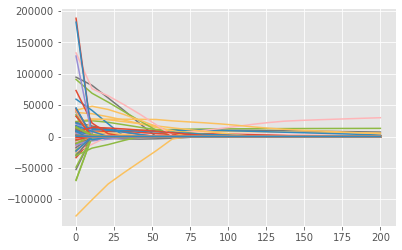

In [93]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

coefs = []
intercepts = []
R2  = []
alphaRange = np.linspace(1e-3,200,20)
for alpha in alphaRange:
          lasso.set_params(alpha=alpha, normalize=True)
          lasso.fit(df2.drop('SalePrice',axis=1), df2['SalePrice'], )
          intercepts.append(lasso.intercept_)
          coefs.append(lasso.coef_)
          R2.append(lasso.score(df2.drop('SalePrice',axis=1), df2['SalePrice']))  
        
        
coefs = pd.DataFrame(np.array(coefs), columns=df2.drop('SalePrice',axis=1).columns)

for name in coefs.columns:
    plt.plot(alphaRange,coefs[name], label=name)
#plt.legend(loc=1)    
#plt.title('Change of Ridge Slopes Varying Alpha')

In [98]:
for i in range(0,len(coefs.columns)-1):
    coefs.iloc[20,i]=coefs.iloc[:,i].searchsorted(0.01, side='left')

In [95]:
coefs.iloc[0,len(coefs.columns)-1]
    

490.6209715732037

In [97]:
coefs=coefs.append(pd.Series(name='Check'))

<ipython-input-97-d514afc6ba01>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  coefs=coefs.append(pd.Series(name='Check'))


In [99]:
print(coefs.iloc[20,:])

PID                                                           20.0
GrLivArea                                                      0.0
MSSubClass                                                    20.0
LotFrontage                                                   20.0
LotArea                                                       20.0
OverallQual                                                    0.0
drop_OverallCond                                              20.0
YearBuilt                                                      0.0
YearRemodAdd                                                   0.0
MasVnrArea                                                     0.0
ExterQual                                                      0.0
drop_ExterCond                                                20.0
drop_BsmtFinSF1                                                0.0
drop_BsmtFinSF2                                               20.0
maybe_BsmtUnfSF                                               

In [122]:
pd.options.display.max_rows=400

In [100]:
coefs

,PID,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,drop_OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,"Electrical_com_>60 Amp fuse box, all Romex wiring","Electrical_com_Standard circuit breakers, all Romex wiring",LotConfig_com_2+ sides frontage,LotConfig_com_Corner lot,LotConfig_com_Cul-de-sac lot,LotConfig_com_Inside lot (1 side frontage),GarageType_con_0,GarageType_con_Attchd,GarageType_con_BuiltIn,GarageType_con_Detchd
0,0.000006,82.507523,-43.041984,-38.507435,0.182326,6529.464385,5937.638595,341.069983,44.600977,26.601674,...,-4108.226151,-5221.049178,8176.020828,-1396.345013,2430.769114,-34.149801,13921.019228,-1182.605418,-1730.635445,490.620972
1,-0.000000,49.873867,-28.160338,2.164213,0.183957,7087.475064,5001.407938,254.862160,37.347047,23.992322,...,0.000000,-0.000000,-4850.997406,-0.000000,120.368784,0.000000,3147.930053,-0.000000,0.000000,-0.000000
2,-0.000000,47.233144,-16.579689,0.000000,0.187215,8015.165853,4080.957347,226.115432,50.426386,19.916718,...,-0.000000,-0.000000,-1508.196601,-0.000000,102.082488,0.000000,0.000000,0.000000,0.000000,-0.000000
3,-0.000000,44.967468,-0.000000,0.000000,0.156873,8922.203493,3269.742148,207.194564,56.707648,18.722124,...,-0.000000,0.000000,-0.000000,-0.000000,55.664277,-0.000000,0.000000,0.000000,0.000000,-0.000000
4,-0.000000,43.920052,-0.000000,0.000000,0.120039,9808.062544,2456.547697,181.921896,61.617602,17.484282,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
5,-0.000000,43.038703,-0.000000,0.000000,0.072214,10634.259549,1562.759629,152.371699,63.548024,16.410942,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
6,-0.000000,42.181813,-0.000000,0.000000,0.014595,11236.015292,713.603277,112.648320,66.057485,15.837433,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
7,-0.000000,41.380782,-0.000000,0.000000,0.000000,11724.775520,0.000000,80.869982,66.950211,15.214716,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
8,-0.000000,40.836464,-0.000000,0.000000,0.000000,12012.994454,0.000000,67.041610,51.747629,14.602238,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
9,-0.000000,40.503488,-0.000000,0.000000,0.000000,12191.902633,0.000000,52.235934,35.385348,14.095998,...,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000


In [106]:
df['MSSubClass'].unique()

array([ 30, 120,  70,  60,  85,  20, 180,  80, 160,  50,  90,  75,  45,
       190,  40, 150])

In [ ]:
dicti={
    30:'', 
    120,  
    70,  
    60,  
    85, 
    20, 
    180,  
    80, 
    160,  
    50, 
    90,  
    75,  
    45,
    190,  
    40, 
    150
    
}

In [109]:
MB_dict = {
    20: "1-Story",
    30: "1-Story",
    40: "1-Story",
    120: "1-Story",
    45: "1.5-Story",
    50: "1.5-Story",
    150: "1.5-Story",
    60: "2-Story",
    70: "2-Story",
    160: "2-Story",
    75: "2.5-Story",
    80: "SplitMulti",
    180: "SplitMulti",
    190: "2FamConv",
    85: "SptFoyer",
    90: "Duplex"
};
df["MS_coded"] = df["MSSubClass"].apply(lambda x: MB_dict[x])

In [135]:
df['2ndfloor_bol']=df['2ndFlrSF']!=0

In [148]:
df['HouseStyle'].value_counts()

1Story    1288
2Story     773
1.5Fin     284
SLvl       118
SFoyer      70
2.5Unf      22
1.5Unf      19
2.5Fin       6
Name: HouseStyle, dtype: int64

In [160]:
def calc_floors(feat1, feat2):
    floors = []
    zipped = zip(feat1, feat2)
    for item in zipped: 
        if item[0] in ['1-Story', '1.5-Story', '2-Story', '2.5-Story']:
            ms_coded_dict = {
                '1-Story' : 1,
                '1.5-Story' : 1,
                '2-Story' : 2,
                '2.5-Story' : 2
            }
            floors.append(ms_coded_dict[item[0]])
        else:
            HouseStyle_dict = {
                '1Story' : 1,
                '1.5Fin' : 1,
                '1.5Unf' : 1,
                '2Story' : 2,
                '2.5Fin' : 2,
                '2.5Unf' : 2,
                'SLvl' : 2,
                'SFoyer' : 2
            }
            floors.append(HouseStyle_dict[item[1]])
    return floors

In [161]:
df['number_floors'] = calc_floors(df['MS_coded'], df['HouseStyle'])

In [162]:
df.loc[:, ['MS_coded', 'HouseStyle','number_floors']].value_counts()

MS_coded    HouseStyle  number_floors
1-Story     1Story      1                1230
2-Story     2Story      2                 730
1.5-Story   1.5Fin      1                 256
SplitMulti  SLvl        2                 114
Duplex      1Story      1                  45
SptFoyer    SFoyer      2                  43
Duplex      2Story      2                  22
2FamConv    1.5Fin      1                  18
1.5-Story   1.5Unf      1                  17
2FamConv    2Story      2                  15
2.5-Story   2.5Unf      2                  15
2FamConv    1Story      1                  13
Duplex      SFoyer      2                  13
SplitMulti  SFoyer      2                  10
2.5-Story   2.5Fin      2                   5
Duplex      1.5Fin      1                   5
1.5-Story   2Story      1                   4
2FamConv    2.5Unf      2                   3
1-Story     1.5Fin      1                   3
2-Story     2.5Unf      2                   3
2FamConv    SFoyer      2                 

In [163]:
def calc_attic(feat1):
    attic = []
    for item in feat1: 
        if not (item in ['1.5Fin', '1.5Unf', '2.5Fin', '2.5Unf']):
            attic.append('No attic')
        else:
            if 'Fin' in item:
                attic.append('Finished')
            if 'Unf' in item:
                attic.append('Unfinished')
    return attic

In [164]:
df['attic'] = calc_attic(df['HouseStyle'])

In [166]:
df['attic'].value_counts()

No attic      2249
Finished       290
Unfinished      41
Name: attic, dtype: int64

In [167]:
df['PUD'] = df['MSSubClass'].apply(lambda x: 1 if x in [120, 150, 160, 180] else 0)

In [169]:
df['PUD'].value_counts()

0    2275
1     305
Name: PUD, dtype: int64

In [171]:
df[(df['MS_coded'] == '2FamConv') & (df['BldgType'] == '1Fam')

,PID,GrLivArea,SalePrice,MSSubClass,maybe_MSZoning,LotFrontage,LotArea,Street_paved,Alley,maybe_LotShape,...,maybe_BSMT_ALQ,maybe_BSMT_BLQ,maybe_BSMT_LwQ,BSMT_Rec,GarageType_con,MS_coded,2ndfloor_bol,number_floors,attic,PUD
653,905226110,1721,145000,190,RL,NaN,10532,Pave,No alley access,Reg,...,0.0,0.0,0.0,988.0,Detchd,2FamConv,False,1,No attic,0


In [173]:
df['BldgType'].value_counts()

1Fam      2139
TwnhsE     202
Twnhs       98
Duplex      87
2fmCon      54
Name: BldgType, dtype: int64

In [172]:
df.loc[653,['BldgType']] = '2FamConv'

PID                                                           905226110
GrLivArea                                                          1721
SalePrice                                                        145000
MSSubClass                                                          190
maybe_MSZoning                                                       RL
LotFrontage                                                         NaN
LotArea                                                           10532
Street_paved                                                       Pave
Alley                                                   No alley access
maybe_LotShape                                                      Reg
LandContour                                                       Level
Utilities                                                          EGWS
drop_LotConfig                                                   Corner
LandSlope                                                       

In [147]:
xxx=df.groupby(['MS_coded','HouseStyle','2ndfloor_bol']).agg('count')
xxx=xxx.reset_index(drop=False)
#xxx=xxx[(xxx['HouseStyle']!='2Story') & (xxx['MS_coded']!='2-Story')  & (xxx['MS_coded']!='2.5-Story')]
#xxx[(xxx['HouseStyle']=='1.5Fin')] #& (xxx['2ndfloor_bol']==False)]
xxx

,MS_coded,HouseStyle,2ndfloor_bol,PID,GrLivArea,SalePrice,MSSubClass,maybe_MSZoning,LotFrontage,LotArea,...,BsmtExposure_ord,BsmtCond_ord_lin,BsmtQual_ord_lin,BsmtExposure_ord_lin,BSMT_GLQ,maybe_BSMT_ALQ,maybe_BSMT_BLQ,maybe_BSMT_LwQ,BSMT_Rec,GarageType_con
0,1-Story,1.5Fin,False,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1-Story,1.5Fin,True,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,1-Story,1.5Unf,False,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
3,1-Story,1Story,False,1227,1227,1227,1227,1227,1012,1227,...,1227,1227,1227,1227,1227,1227,1227,1227,1227,1227
4,1-Story,1Story,True,3,3,3,3,3,2,3,...,3,3,3,3,3,3,3,3,3,3
5,1-Story,2Story,True,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1-Story,SFoyer,False,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
7,1.5-Story,1.5Fin,False,11,11,11,11,11,9,11,...,11,11,11,11,11,11,11,11,11,11
8,1.5-Story,1.5Fin,True,245,245,245,245,245,222,245,...,245,245,245,245,245,245,245,245,245,245
9,1.5-Story,1.5Unf,False,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


In [134]:
xxx[xxx['2ndFlrSF']>0]

,MS_coded,BldgType,HouseStyle,2ndFlrSF,PID,GrLivArea,SalePrice,MSSubClass,maybe_MSZoning,LotFrontage,...,BsmtExposure_ord,BsmtCond_ord_lin,BsmtQual_ord_lin,BsmtExposure_ord_lin,BSMT_GLQ,maybe_BSMT_ALQ,maybe_BSMT_BLQ,maybe_BSMT_LwQ,BSMT_Rec,GarageType_con
1,1-Story,1Fam,1.5Fin,125,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1-Story,1Fam,1.5Fin,343,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,1-Story,1Fam,1Story,144,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1-Story,1Fam,1Story,192,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
7,1-Story,1Fam,1Story,467,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,SplitMulti,1Fam,SLvl,800,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
763,SplitMulti,1Fam,SLvl,1080,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
765,SplitMulti,Twnhs,SFoyer,462,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
766,SplitMulti,Twnhs,SLvl,462,3,3,3,3,3,2,...,3,3,3,3,3,3,3,3,3,3


In [131]:
xxx

PID  GrLivArea  SalePrice  \
MS_coded   BldgType HouseStyle 2ndFlrSF                               
1-Story    1Fam     1.5Fin     0            1          1          1   
                               125          1          1          1   
                               343          1          1          1   
                    1.5Unf     0            1          1          1   
                    1Story     0         1063       1063       1063   
...                                       ...        ...        ...   
SplitMulti Twnhs    SLvl       462          3          3          3   
           TwnhsE   SFoyer     0            5          5          5   
                    SLvl       0            2          2          2   
SptFoyer   1Fam     SFoyer     0           42         42         42   
                               1427         1          1          1   

                                         MSSubClass  maybe_MSZoning  \
MS_coded   BldgType HouseStyle 2ndFlrSF                               
1-Story    1Fam     1.5Fin     0                  1               1   
                               125                1               1   
                               343                1               1   
                    1.5Unf     0                  1               1   
                    1Story     0               1063            1063   
...                                             ...             ...   
SplitMulti Twnhs    SLvl       462                3               3   
           TwnhsE   SFoyer     0                  5               5   
                    SLvl       0                  2               2   
SptFoyer   1Fam     SFoyer     0                 42              42   
                               1427               1               1   

                                         LotFrontage  LotArea  Street_paved  \
MS_coded   BldgType HouseStyle 2ndFlrSF                                       
1-Story    1Fam     1.5Fin     0                   1        1             1   
                               125                 1        1             1   
                               343                 1        1             1   
                    1.5Unf     0                   0        1             1   
                    1Story     0                 879     1063          1063   
...                                              ...      ...           ...   
SplitMulti Twnhs    SLvl       462                 2        3             3   
           TwnhsE   SFoyer     0                   5        5             5   
                    SLvl       0                   2        2             2   
SptFoyer   1Fam     SFoyer     0                  27       42            42   
                               1427                1        1             1   

                                         Alley  maybe_LotShape  ...  \
MS_coded   BldgType HouseStyle 2ndFlrSF                         ...   
1-Story    1Fam     1.5Fin     0             1               1  ...   
                               125           1               1  ...   
                               343           1               1  ...   
                    1.5Unf     0             1               1  ...   
                    1Story     0          1063            1063  ...   
...                                        ...             ...  ...   
SplitMulti Twnhs    SLvl       462           3               3  ...   
           TwnhsE   SFoyer     0             5               5  ...   
                    SLvl       0             2               2  ...   
SptFoyer   1Fam     SFoyer     0            42              42  ...   
                               1427          1               1  ...   

                                         BsmtExposure_ord  BsmtCond_ord_lin  \
MS_coded   BldgType HouseStyle 2ndFlrSF                                       
1-Story    1Fam     1.5Fin     0                        1                 1   
     